In [342]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scpi
from scipy.signal import butter, lfilter, hilbert

In [343]:
#u(t) = cos(2pi*fc*t + phi(t))
#fm -> phi(t) = 2*pi*kf integral(m(t)), m(t) é a mensagem
#Pm -> phi(t) = kp*m(t) é a mensagem

#parametros da simulação
ts = 0.0001
fs = 1/ts
fc = 250
T = 0.1 # tempo de simulação
N = int(T*fs) #número de pontos
t = np.linspace(0,N-1,N)*ts #- N*ts/2 linha de tempo deslocada em ts/2
f  = np.linspace(-fs/2,fs/2,N) #banda de frequencia de amostragem
kf = 100 #índice de modulação

In [344]:
#mensagem
#mensagem do tipo sinc(100t)
fm =100
m_t =np.sinc(fm*t)

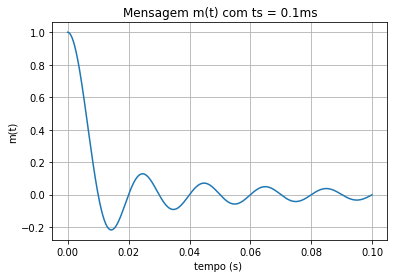

In [345]:
plt.plot(t,m_t)
plt.grid()
plt.title("Mensagem m(t) com ts = 0.1ms")
plt.xlabel("tempo (s) ")
plt.ylabel("m(t)")
plt.show()

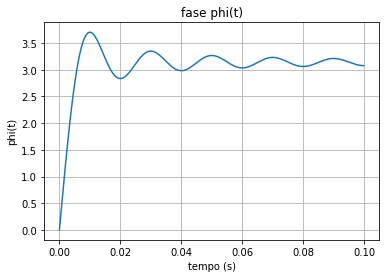

In [346]:
phi_t = 2*np.pi*kf*scpi.cumtrapz(m_t,t,initial=0) #fase phi(t) para sinal FM
plt.plot(t,phi_t)
plt.grid()
plt.xlabel('tempo (s)')
plt.ylabel('phi(t)')
plt.title('fase phi(t)')
plt.show()

In [347]:
#sinal FM
u_t = np.cos(2*np.pi*fc*t + phi_t)

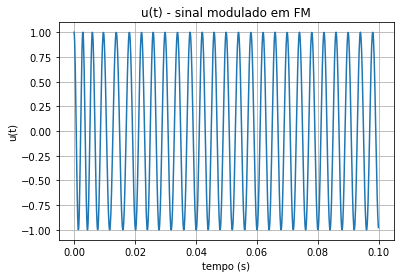

In [348]:
plt.plot(t,u_t)
#plt.plot(t,m_t)
plt.grid()
plt.xlabel('tempo (s)')
plt.ylabel('u(t)')
plt.title('u(t) - sinal modulado em FM')
plt.show()

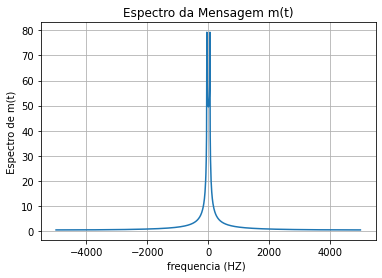

In [349]:
# <h3> Explicação de sinal modulado <h3/>
#<p>A frequencia está sendo alterada, ela tem uma regularidade porque o seno tem uma regularidade, o seno
# que contem a informação,a fase vária de acordo com o ritmo que vária a informação.
# ajustando o kf consguimos ajustar o descolamento do sinal modulado,kf é disvio maximo de frequencia</p>

#analise em frequencia
#relação nao linear entre u(t) e m(t)
M_F = np.fft.fftshift(np.fft.fft(m_t)) #espectro de frequencia da mensagem
plt.plot(f,np.abs(M_F))
plt.grid()
plt.xlabel('frequencia (HZ) ')
plt.ylabel(' Espectro de m(t) ')
plt.title('Espectro da Mensagem m(t)')
plt.show()

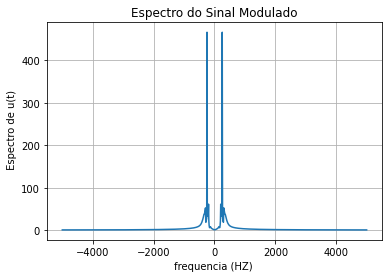

In [350]:
U_F = np.fft.fftshift(np.fft.fft(u_t)) #espectro de frequencia da mensagem
plt.plot(f,np.abs(U_F))
plt.grid()
plt.xlabel('frequencia (HZ) ')
plt.ylabel(' Espectro de u(t)')
plt.title("Espectro do Sinal Modulado")
plt.show()


In [351]:
#demodulação

#osciladores locais
c_t = np.cos(2*np.pi*fc*t)
s_t =np.sin(2*np.pi*fc*t)


In [352]:
# fase
u_i =u_t*c_t + np.imag(hilbert(u_t))*s_t
#a transformada de hilbert é um filtro defasador, np.imag para extrair a parte complexa
#quadratura
u_q = np.imag(hilbert(u_t))*c_t -u_t*s_t

#sinal de banda báscia
u_l =u_i + 1j*u_q


In [353]:
phase_inst =np.unwrap(np.arctan2(u_q,u_i))

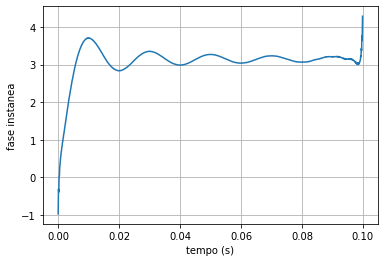

In [354]:
plt.plot(t,phase_inst)
plt.grid()
plt.xlabel('tempo (s)')
plt.ylabel('fase instanea')
plt.show()

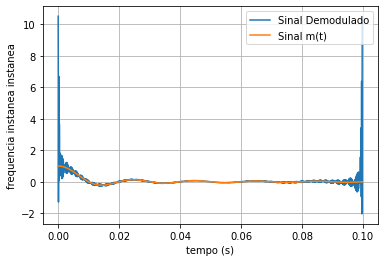

In [355]:
freq_inst = np.diff(phase_inst)/(2*np.pi*kf*ts) #np,diff faz a diferença entre os pontos, mas para ser a aproximaçao da derivada tempop temos que dividir por delta T no caso o tempo de amostragem ts
plt.plot(t[0:N-1],freq_inst,label="Sinal Demodulado")
#na derida o freq_inst fica faltando um ponto ai o t tem que ter menos 1 ponto para o plot de 0 até N-1
plt.plot(t,m_t, label="Sinal m(t)")
plt.grid()
plt.xlabel('tempo (s)')
plt.ylabel('frequencia instanea instanea')
plt.legend(loc=1)
plt.show()

In [356]:
#observações
#Na pratica quando os sinais são mais complixados, a parte de phase_inst , pegamos iuam fase de -pi a pi, se a mensagem
#tem um ranger maior de doq -pi a pi, a função vai ser cortada, para corrigir é necessario
#mutiplica np.unwrap()

#demodulação com filtro passabaixa
def butter_lowpass(cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [357]:
cutoff1 =25
cutoff2 =125
cutoff3=250

hat_u_i_1 = butter_lowpass_filter(u_t*c_t,cutoff1,fs)
hat_u_q_1 = butter_lowpass_filter(u_t*s_t,cutoff1,fs)
hat_u_i_2 = butter_lowpass_filter(u_t*c_t,cutoff2,fs)
hat_u_q_2 = butter_lowpass_filter(u_t*s_t,cutoff2,fs)
hat_u_i_3 = butter_lowpass_filter(u_t*c_t,cutoff3,fs)
hat_u_q_3 = butter_lowpass_filter(u_t*s_t,cutoff3,fs)

In [358]:
phase_inst1 = np.unwrap(np.arctan2(hat_u_q_1,hat_u_i_1))
freq_inst1 = np.diff(phase_inst1)/(2*np.pi*kf*ts)
phase_inst2 = np.unwrap(np.arctan2(hat_u_q_2,hat_u_i_2))
freq_inst2 = np.diff(phase_inst2)/(2*np.pi*kf*ts)
phase_inst3 = np.unwrap(np.arctan2(hat_u_q_3,hat_u_i_3))
freq_inst3 = np.diff(phase_inst3)/(2*np.pi*kf*ts)

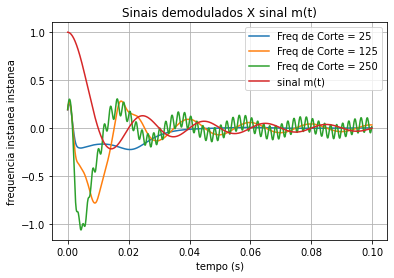

In [359]:
plt.plot(t[0:N-1],freq_inst1,label="Freq de Corte = 25")
plt.plot(t[0:N-1],freq_inst2,label="Freq de Corte = 125")
plt.plot(t[0:N-1],freq_inst3,label="Freq de Corte = 250")
plt.plot(t,m_t,'-', label="sinal m(t)")
plt.grid()
plt.legend(loc=1)
plt.xlabel('tempo (s)')
plt.ylabel('frequencia instanea instanea')
plt.title("Sinais demodulados X sinal m(t)")
plt.show()